# Titanic乘客生存预测——机器学习项目一般流程总结

本文以Kaggle上Titanic乘客生存预测项目为例，总结梳理机器学习项目的一般流程，为今后做机器学习项目提供一个参考。

# 目录
1. 定义问题
  - 1.1 项目描述
  - 1.2 导入类库
  - 1.3 导入数据集
2. 理解数据
  - 2.1 数据概览
  - 2.2 数据探索分析
    - 2.2.1 分析各数值变量的相关度
    - 2.2.2 分析目标变量的分布
    - 2.2.3 分析特征变量的分布
3. 特征工程
  - 3.1 缺失值处理
  - 3.2 衍生变量
  - 3.3 离散特征处理
  - 3.4 连续特征处理
  - 3.5 数值特征标准化
  - 3.6 去掉无用的特征
4. 构建模型
  - 4.1 分离数据集
  - 4.2 模型选择
    - 4.2.1 调参
    - 4.2.2 交叉验证
  - 4.3 模型训练
5. 模型融合
  - 5.1 voting
  - 5.2 stacking
6. 总结
7. 参考资料

# 1. 定义问题
主要是分析项目需求，导入在机器学习项目中所需要的类库和数据集等，以便完成机器学习的项目。

## 1.1 项目描述
项目地址：[Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic)
- 发生在1912年的泰坦尼克号沉船事件，船上2224名游客死亡1502名。由于救生艇有限，大部分乘客死亡，但是一部分乘客的生还率比较高，比如妇女、小孩和高等舱位乘客，因此我们希望探索数据，获取乘客是否获救的规律
- 训练和测试数据是一些乘客的个人信息以及存活状况，根据提供的数据生成合适的模型，预测其他人是否获救
- 这是一个二分类问题

## 1.2 导入类库

In [1]:
# 数据处理
import numpy as np
import pandas as pd

# 可视化
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 机器学习
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

## 1.3 导入数据集

In [2]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
# 合并训练集和测试集，方便同时对两个数据集进行数据处理
combine_df = pd.concat([train_df, test_df], axis=0)

# 2. 理解数据
这是加强对数据理解的步骤，包括通过描述性统计来分析数据和通过可视化来观察数据。

## 2.1 数据概览
对数据的简单审视，是加强对数据理解最有效的方法之一，包括查看前几行数据、数据维度、数据的描述统计信息等操作。

In [3]:
# 查看前几行数据
combine_df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [4]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


数据集各列的含义
- PassengerId => 乘客ID
- Pclass => 客舱等级(1/2/3等舱位)
- Name => 乘客姓名
- Sex => 性别
- Age => 年龄
- SibSp => 堂兄弟/妹个数
- Parch => 父母与小孩个数
- Ticket => 船票信息
- Fare => 票价
- Cabin => 客舱号
- Embarked => 登船港口

要预测的属性
- Survived => 是否生还(0死亡、1生还)

In [5]:
# 数据维度
print('训练集维度：%s，测试集维度：%s，合并集维度：%s' % (train_df.shape, test_df.shape, combine_df.shape))

训练集维度：(891, 12)，测试集维度：(418, 11)，合并集维度：(1309, 12)


In [6]:
# 查看每列数据的数据类型和数据总数
# 可以看出Age, Cabin, Embarked, Fare有缺失值，Cabin、Age缺失值比例较高
combine_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


In [7]:
# 获取数据的描述统计信息，包括数据记录数、均值、标准差、最小值、下四分位数、中位数、上四分位数、最大值
combine_df.describe()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,29.881138,33.295479,0.385027,655.000000,2.294882,0.498854,0.383838
std,14.413493,51.758668,0.865560,378.020061,0.837836,1.041658,0.486592
min,0.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,328.000000,2.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,655.000000,3.000000,0.000000,0.000000
75%,39.000000,31.275000,0.000000,982.000000,3.000000,1.000000,1.000000
max,80.000000,512.329200,9.000000,1309.000000,3.000000,8.000000,1.000000


## 2.2 数据探索分析
查看数据分布，分析数据之间的关系，对数据进行探索性的分析，一般通过可视化操作来理解数据。

**可视化一般使用pandas、matplotlib和seaborn，比较常用的图表有：**
- 查看目标变量的分布。当分布不平衡时，根据评分标准和具体模型的使用不同，可能会严重影响性能
- 对连续值变量，可以用直方图、箱线图来直观地查看它的分布
- 对离散值变量，可以绘制频率分布图，可以将数据根据类别的不同着不同的颜色绘制出来，这对特征的构造很有帮助
- 对于坐标类数据，可以用散点图来查看它们的分布趋势和是否有离群点的存在
- 绘制变量之间两两的分布和相关度图表

**数据探索分析可能涉及以下方面：**
1. 分析特征变量的分布
  - 特征变量为连续值：如果为长尾分布并且考虑使用线性模型，可以对变量进行幂变换或者对数变换
  - 特征变量为离散值：观察每个离散值的频率分布，对于频次较低的特征，可以考虑统一编码为“其他”类别
2. 分析目标变量的分布
  - 目标变量为连续值：查看其值域范围是否较大，如果较大，可以考虑对其进行对数变换，并以变换后的值作为新的目标变量进行建模（在这种情况下，需要对预测结果进行逆变换）。一般情况下，可以对连续变量进行Box-Cox变换。通过变换可以使得模型更好的优化，通常也会带来效果上的提升。
  - 目标变量为离散值：如果数据分布不平衡，考虑是否需要上采样/下采样；如果目标变量在某个ID上面分布不平衡，在划分本地训练集和验证集的时候，需要考虑分层采样（Stratified Sampling）。
3. 分析变量之间两两的分布和相关度
  - 可以用于发现高相关和共线性的特征
  
通过对数据进行探索性分析（甚至有些情况下需要肉眼观察样本），可以有助于启发数据清洗和特征抽取，譬如缺失值和异常值的处理，文本数据是否需要进行拼写纠正等。

### 2.2.1 分析各数值变量的相关度

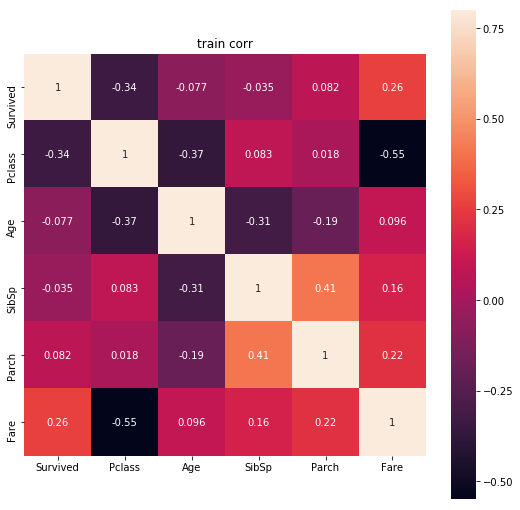

In [8]:
train_corr = train_df.drop('PassengerId', axis=1).corr()
plt.figure(figsize=(9, 9))
sns.heatmap(train_corr, vmax=0.8, annot=True, square=True)
plt.title('train corr')
plt.show()

从上图中可以看出：
- 客舱等级Pclass与是否获救负相关
- 票价Fare与是否获救正相关
- Pclass与Fare负相关

结论基本与常识相符

### 2.2.2 分析目标变量的分布

In [9]:
# 这是一个二分类问题，目标变量Survived(0死亡，1获救)
# 统计乘客获救情况，可以看出获救比例较低，不到半数
train_df.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

Text(0.5,1,'Survived count')

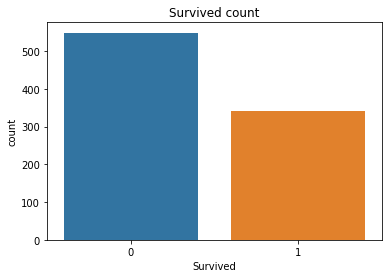

In [10]:
# 作图
sns.countplot(x='Survived', data=train_df)
plt.title('Survived count')

### 2.2.3 分析特征变量的分布

- **Pclass**

Text(0.5,1,'Pclass count')

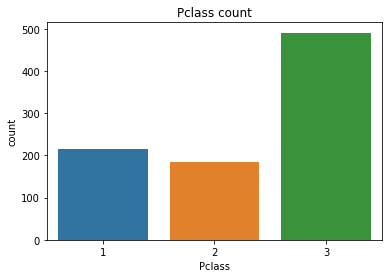

In [11]:
# 乘客等级分布
sns.countplot(x='Pclass', data=train_df)
plt.title('Pclass count')

Text(0.5,1,'Pclass Survived count')

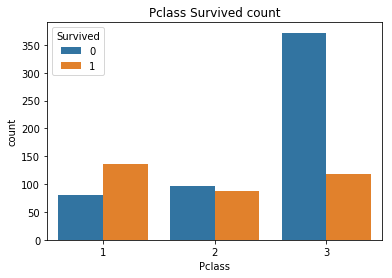

In [12]:
# 客舱各等级乘客获救情况
sns.countplot(x='Pclass', hue='Survived', data=train_df)
plt.title('Pclass Survived count')

Text(0.5,1,'Pclass Survived rate')

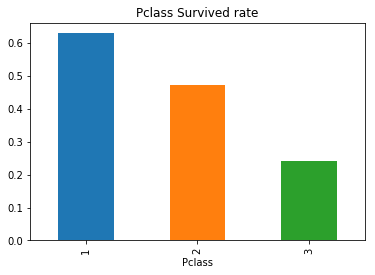

In [13]:
# 客舱各等级乘客获救率
train_df.groupby('Pclass')['Survived'].mean().plot(kind='bar')
plt.title('Pclass Survived rate')

可以看出，头等舱(Pclass=1)获救率最高，这是一个重要的特征

- **Sex**

Text(0.5,1,'Sex count')

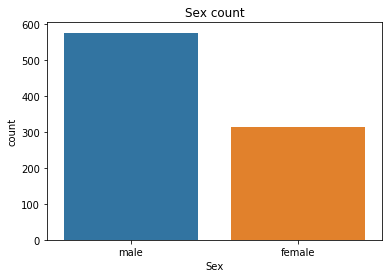

In [14]:
# 乘客性别分布
sns.countplot(x='Sex', data=train_df)
plt.title('Sex count')

Text(0.5,1,'Sex Survived count')

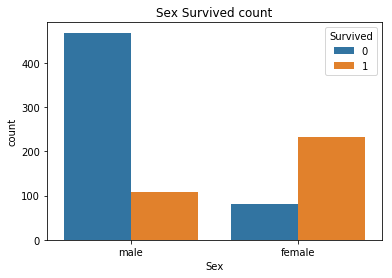

In [15]:
# 各性别获救情况
sns.countplot(x='Sex', hue='Survived', data=train_df)
plt.title('Sex Survived count')

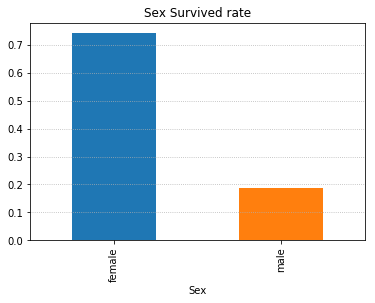

In [16]:
# 各性别获救率
train_df.groupby('Sex')['Survived'].mean().plot(kind='bar')
plt.title('Sex Survived rate')
plt.grid(b=True, ls=':', axis='y')

可以看出女性获救率远高于男性，这也是一个重要的特征。

- **Age**

Text(0.5,1,'Age distribution box')

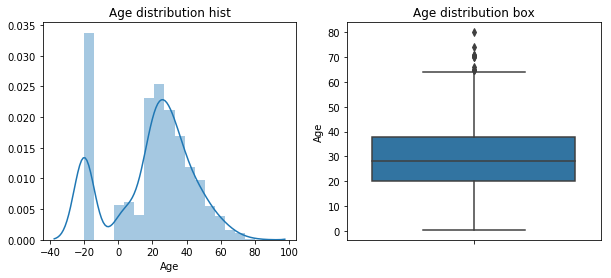

In [17]:
# 年龄的总体分布
plt.figure(figsize=(10, 4))
plt.subplot(121)
sns.distplot(train_df['Age'].fillna(-20)) # 年龄有缺失值，用-20填充
plt.title('Age distribution hist')

plt.subplot(122)
sns.boxplot(y='Age', data=train_df)
plt.title('Age distribution box')

Text(0.5,1,'Age Survived distribution')

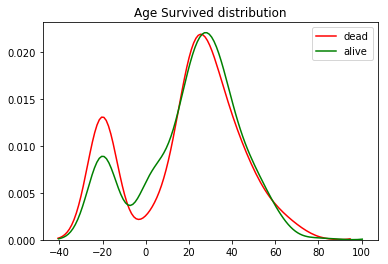

In [18]:
# 获救和未获救情况下的年龄分布
sns.kdeplot(train_df[train_df.Survived==0]['Age'].fillna(-20), color='r', label='dead')
sns.kdeplot(train_df[train_df.Survived==1]['Age'].fillna(-20), color='g', label='alive')
plt.title('Age Survived distribution')

从上图中可以看出：
- 年龄缺失值比例较大
- 小孩和年龄中等偏上的获救概率较大
- 年龄跨度比较大，可以考虑对年龄分块做离散化处理

- **Fare**

Text(0.5,1,'Fare distribution')

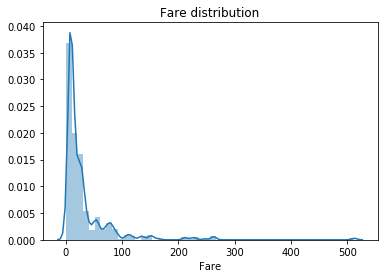

In [19]:
# 票价的分布
sns.distplot(train_df['Fare'])
plt.title('Fare distribution')

Text(0.5,1,'Fare survived distribution')

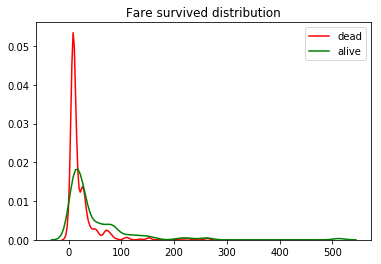

In [20]:
# 获救和未获救情况下票价分布
sns.kdeplot(train_df[train_df.Survived==0]['Fare'], color='r', label='dead')
sns.kdeplot(train_df[train_df.Survived==1]['Fare'], color='g', label='alive')
plt.title('Fare survived distribution')

可以看出，票价高的更容易获救

- **Name**

名字中包含了对乘客的称呼，从称呼中可以得到乘客的性别、年龄、社会地位等信息，可以提取出来作为一个特征，分析其与是否获救的关系

In [21]:
train_df['Name'].apply(lambda x: x.split(', ')[1].split('.')[0]).value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Major             2
Mlle              2
Lady              1
Don               1
Jonkheer          1
Ms                1
Sir               1
Capt              1
Mme               1
the Countess      1
Name: Name, dtype: int64

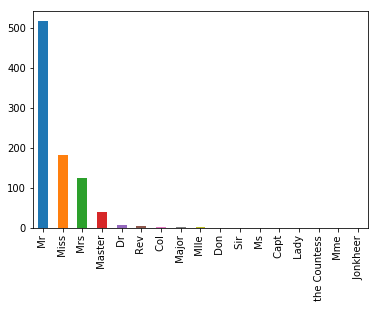

In [22]:
train_df['Name'].apply(lambda x: x.split(',')[1].split('.')[0]).value_counts().plot(kind='bar')

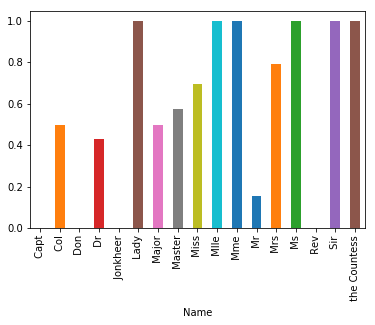

In [23]:
# 各个称呼的获救率
train_df.groupby(train_df['Name'].apply(lambda x: x.split(',')[1].split('.')[0]))['Survived'].mean().plot(kind='bar')

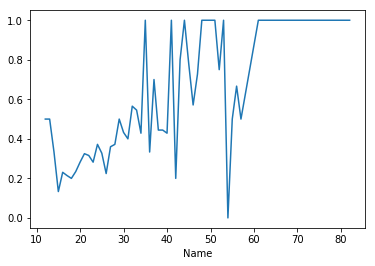

In [24]:
# 分析名字长度与获救率的关系
train_df.groupby(train_df['Name'].apply(lambda x: len(x)))['Survived'].mean().plot()

- 不同的称呼获救率显著不同
- 名字长度和获救率相关  
可以把称呼、名字长度加入特征

- **SibSp & Parch**

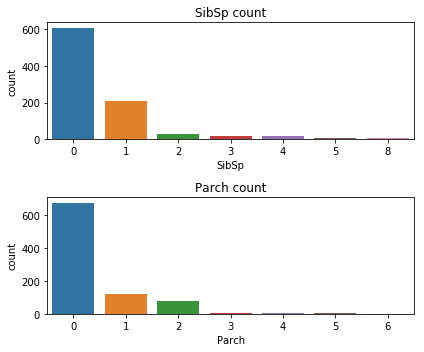

In [25]:
# 表亲和直亲的分布
plt.figure(figsize=(6, 5))
plt.subplot(211)
sns.countplot(x='SibSp', data=train_df)
plt.title('SibSp count')

plt.subplot(212)
sns.countplot(x='Parch', data=train_df)
plt.title('Parch count')

plt.tight_layout()

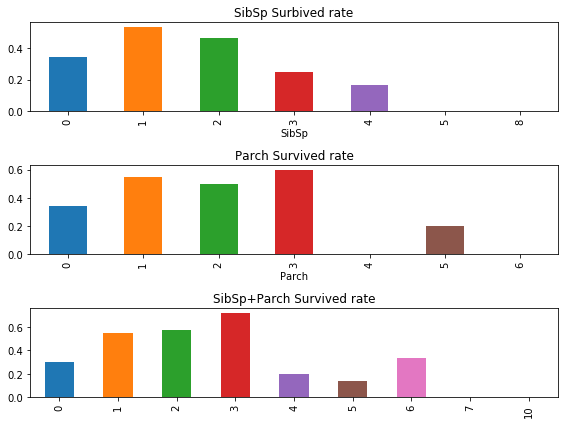

In [26]:
# 不同亲属人数的生存率
plt.figure(figsize=(8, 6))
plt.subplot(311)
train_df.groupby('SibSp')['Survived'].mean().plot(kind='bar')
plt.title('SibSp Surbived rate')

plt.subplot(312)
train_df.groupby('Parch')['Survived'].mean().plot(kind='bar')
plt.title('Parch Survived rate')

plt.subplot(313)
train_df.groupby(train_df.SibSp + train_df.Parch)['Survived'].mean().plot(kind='bar')
plt.title('SibSp+Parch Survived rate')

plt.tight_layout()

- 大多数没有亲属，表亲1个居多，直亲1、2个居多
- 获救率随着亲属人数的增加呈现先高到低的趋势
- 可以考虑两个变量组合成一个亲属人数的特征：SibSp+Parch

- **Embarked**

Text(0.5,1,'Embarked count')

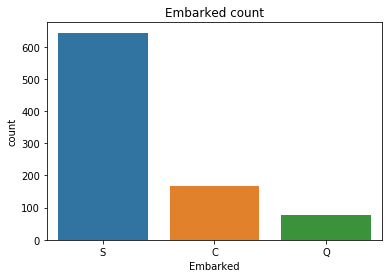

In [27]:
# 登陆港口分布
sns.countplot(x='Embarked', data=train_df)
plt.title('Embarked count')

Text(0.5,1,'Embarked survived count')

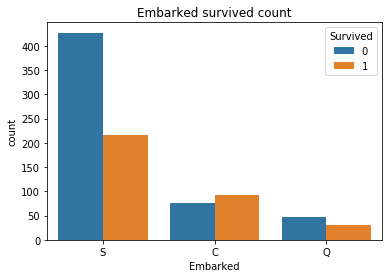

In [28]:
# 各个港口的获救情况
sns.countplot(x='Embarked', hue='Survived', data=train_df)
plt.title('Embarked survived count')

Text(0.5,1,'Embared survived rate')

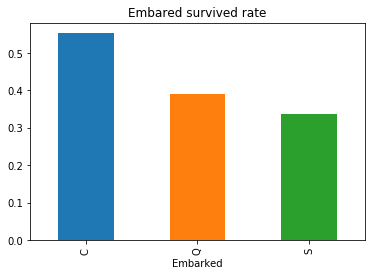

In [29]:
# 各个港口的获救率
train_df.groupby('Embarked')['Survived'].mean().plot(kind='bar')
plt.title('Embared survived rate')

- S港口登陆乘客最多
- C港口获救率最高

- **Cabin**

Text(0.5,1,'cabin count')

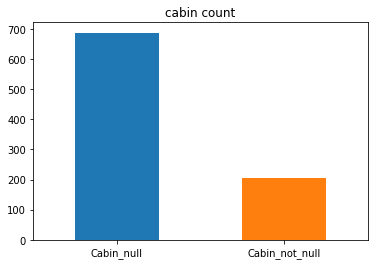

In [30]:
fig, ax = plt.subplots()
train_df.Cabin.isnull().value_counts().plot(kind='bar', ax=ax)
ax.set_xticklabels(['Cabin_null', 'Cabin_not_null'], rotation=0)
ax.set_title('cabin count')

Text(0.5,1,'cabin survived rate')

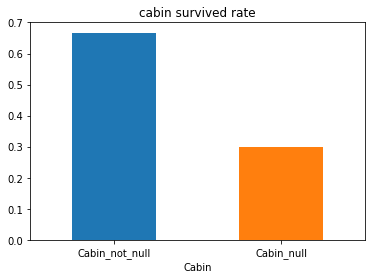

In [31]:
fig, ax = plt.subplots()
train_df.groupby(train_df.Cabin.isnull())['Survived'].mean().plot(kind='bar', ax=ax)
ax.set_xticklabels(['Cabin_not_null', 'Cabin_null'], rotation=0)
ax.set_title('cabin survived rate')

Cabin缺失值比例很高，把是否记录作为特征，分析与是否获救的关系，从图中看出不为空的获救率高，为空的获救率低，可以作为一个特征。

- **Ticket**

Ticket是船票编号，无法直接使用。Ticket以字母或者数字开头，从Ticket中分离出首字母，分析与是否获救有没有关系

Text(0,0.5,'count')

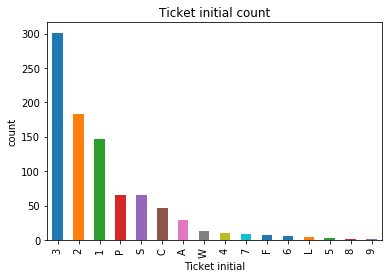

In [32]:
# Ticket首字母分布
train_df.Ticket.apply(lambda x: x[0]).value_counts().plot(kind='bar')
plt.title('Ticket initial count')
plt.xlabel('Ticket initial')
plt.ylabel('count')

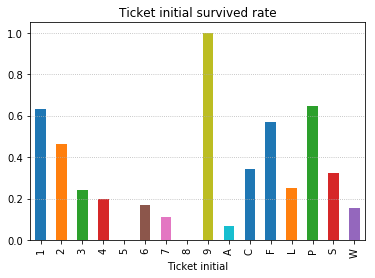

In [33]:
# Ticket各个首字母的获救率
train_df.groupby(train_df.Ticket.apply(lambda x: x[0]))['Survived'].mean().plot(kind='bar')
plt.title('Ticket initial survived rate')
plt.xlabel('Ticket initial')
plt.grid(b=True, ls=':', axis='y')

- 可以挑选出高频字母中获救率较高和较低的作为特征
- 高频字母中获救率较高的为：1,2,P
- 高频字母中获救率较低的为：A,7,W,3

# 3. 特征工程

有一句话在业界广泛流传：数据和特征决定了机器学习的上限，而模型和算法只是逼近这个上限而已。所以特征工程非常非常的重要！特征工程本质是一项工程活动，目的是最大限度地从原始数据中提取特征以供算法和模型使用。通过总结和归纳，特征工程通常包括以下方面：
- 数据清洗。清洗异常样本，分层采样不均衡样本等
- 数据预处理
- 特征选择
- 降维

### 数据预处理主要包括以下工作：
- 数据无量纲化。特征的规格不一样，不能够放在一起比较。无量纲化使不同规格的数据转换到同一规格，常见的无量纲化方法有标准化、区间缩放法、归一化。
- 离散特征哑编码。某些机器学习算法和模型只能接受连续特征的输入，那么需要将离散特征转换为连续特征。通常使用哑编码的方式将离散特征转换为连续特征：假设有N种离散值，则将这一个特征扩展为N种特征，当原始特征值为第i种离散值时，第i个扩展特征赋值为1，其他扩展特征赋值为0。
- 连续特征二值化。对于某些连续特征，其包含的有效信息为区间划分，例如学习成绩，假若只关心“及格”或不“及格”，那么需要将连续的考分，转换成“1”和“0”表示及格和未及格。二值化可以解决这一问题。
- 连续特征离散化。一些连续值范围绝大的特征，不做离散化处理很容易过拟合。可以通过分箱处理等频或者等距的方式进行离散化操作
- 数据变换。对连续特征对数变换、指数变换、多项式变换、Box-Cox变换
- 衍生变量。对原始数据加工，生成有商业意义的变量
- 缺失值处理

### 特征选择

当数据预处理完成后，我们需要选择有意义的特征输入机器学习的算法和模型进行训练。通常来说，从两个方面考虑来选择特征：
- 特征是否发散：如果一个特征不发散，例如方差接近于0，也就是说样本在这个特征上基本上没有差异，这个特征对于样本的区分并没有什么用。
- 特征与目标的相关性：这点比较显见，与目标相关性高的特征，应当优选选择。

根据特征选择的形式又可以将特征选择方法分为3种：
- Filter：过滤法，按照发散性或者相关性对各个特征进行评分，设定阈值或者待选择阈值的个数，选择特征。
- Wrapper：包装法，根据目标函数（通常是预测效果评分），每次选择若干特征，或者排除若干特征。
- Embedded：嵌入法，先使用某些机器学习的算法和模型进行训练，得到各个特征的权值系数，根据系数从大到小选择特征。类似于Filter方法，但是是通过训练来确定特征的优劣。

### 降维
当特征选择完成后，可以直接训练模型了，但是可能由于特征矩阵过大，导致计算量大，训练时间长的问题，因此降低特征矩阵维度也是必不可少的。常见的降维方法有基于L1惩罚项的模型、主成分分析法（PCA）和线性判别分析（LDA）。

## 3.1 缺失值处理
- 特征值为连续值：按不同的分布类型对缺失值进行补全：偏正态分布，使用均值代替，可以保持数据的均值；偏长尾分布，使用中值代替，避免受 outlier 的影响
- 特征值为离散值：使用众数代替
- 有些情况下，缺失的值个数并不是特别多，也可以试着根据已有的值，建立模型拟合一下数据，对缺失值进行预测补充上。

In [34]:
# 查看数据集缺失情况
combine_df.isnull().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

### (1) Fare

In [35]:
# Fare缺失值用众数补全
combine_df.Fare.fillna(combine_df.Fare.mode()[0], inplace=True) # mode()取众数，返回一个Series

### (2) Embarked

In [36]:
# Embarked缺失值用众数补全
combine_df.Embarked.fillna(combine_df.Embarked.mode()[0], inplace=True)

### (3) Cabin

In [37]:
# Cabin缺失值处理，根据前面的分析，按有无数据，分成'Yes' / 'No'两个类别
combine_df.Cabin = np.where(combine_df.Cabin.notnull(), 'Yes', 'No')

### (4) Age
Age缺失值较多，简单的用均值填充会为模型加入较大的噪声，可考虑结合名字中的称呼，利用不同称呼的平均年龄来填充

In [38]:
"""
从Name中提取头衔，对头衔做分类
'Capt', 'Col', 'Major', 'Dr', 'Rev'--> 'Officer'(政府官员)
'Don', 'Sir', 'the Countess', 'Dona', 'Lady','Jonkheer'--> 'Royalty'(王室)
'Mme', 'Ms', 'Mrs'-->'Mrs'(已婚女士)
'Mlle', 'Miss'-->'Miss'(年轻未婚女士)
'Mr'-->'Mr'(已婚男士)
'Master'--> 'Master'(有技能的人)
"""
combine_df['Title'] = combine_df['Name'].apply(lambda x: x.split(', ')[1].split('.')[0]) # 注：分隔符是逗号加空格
combine_df['Title'].replace(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer', inplace=True)
combine_df['Title'].replace(['Don', 'Sir', 'the Countess', 'Dona', 'Lady','Jonkheer'], 'Royalty', inplace=True)
combine_df['Title'].replace(['Mme', 'Ms'], 'Mrs', inplace=True)
combine_df['Title'].replace('Mlle', 'Miss', inplace=True)

In [39]:
combine_df.groupby('Title')['Age'].mean()

Title
Master      5.482642
Miss       21.795236
Mr         32.252151
Mrs        36.866279
Officer    46.272727
Royalty    41.166667
Name: Age, dtype: float64

In [40]:
# 使用每个头衔的平均年龄填充缺失值
combine_df['Age'] = combine_df.groupby('Title')['Age'].transform(lambda x: x.fillna(x.mean()))

In [41]:
# 检查缺失值处理情况，缺失值处理完毕
combine_df.isnull().sum()

Age              0
Cabin            0
Embarked         0
Fare             0
Name             0
Parch            0
PassengerId      0
Pclass           0
Sex              0
SibSp            0
Survived       418
Ticket           0
Title            0
dtype: int64

## 3.2 衍生变量
对原始特征加工生成新的特征变量

### (1) FamilySize

In [42]:
"""
建立FamilySize特征表示家庭人数
FamilySize = SibSp + Parch + 1（包括乘客自己）
分类：
Single: FamilySize=1
Small: 2<=FamilySize<=4
Large: FamilySize>=5
"""
combine_df['FamilySize'] = combine_df['SibSp'] + combine_df['Parch'] + 1
combine_df['FamilySize'] = np.where(combine_df['FamilySize']==1, 'Single', np.where(combine_df['FamilySize']<=4, 'Small', 'Large'))
dummies_FamilySize = pd.get_dummies(combine_df['FamilySize'], prefix='FamilySize')
combine_df = pd.concat([combine_df, dummies_FamilySize], axis=1)

### (2) Title

In [43]:
# 在前面填充Age缺失值时，已经从Name中建立了Title特征
# 对Title特征one-hot编码
dummies_Title = pd.get_dummies(combine_df['Title'], prefix='Title')
combine_df = pd.concat([combine_df, dummies_Title], axis=1)

### (3)有女性死亡的家庭 & 有男性存活的家庭
在泰坦尼克事件中，女性死亡和男性存活都是小概率事件，模型会很容易判断女性乘客存活、男性乘客死亡，为了提升模型对于这一类群体的识别能力，通过分析数据发现，同一个family下的生存死亡模式有很大程度上是相同的，例如：有一个family有一个女性死亡，这个family其他的女性的死亡概率也比较高。因此新建特征标注这类特殊的群体

In [44]:
combine_df['Fname'] = combine_df['Name'].apply(lambda x:x.split(',')[0])

In [45]:
dead_female_Fname = list(set(combine_df[(combine_df.Sex=='female') & (combine_df.Age>=12)
                              & (combine_df.Survived==0) & (combine_df.SibSp+combine_df.Parch>1)]['Fname'].values))
survive_male_Fname = list(set(combine_df[(combine_df.Sex=='male') & (combine_df.Age>=12)
                              & (combine_df.Survived==1) & (combine_df.SibSp+combine_df.Parch>1)]['Fname'].values))
combine_df['Dead_female_family'] = np.where(combine_df['Fname'].isin(dead_female_Fname),1,0)
combine_df['Survive_male_family'] = np.where(combine_df['Fname'].isin(survive_male_Fname),1,0)

### (4) IsChild

In [46]:
# 年龄小的乘客获救率较高，添加一个IsChild特征
combine_df['IsChild'] = np.where(combine_df['Age']<=12, 1, 0)

### (5) Ticket

In [47]:
"""
Ticket属性加工
根据前面对Ticket首字母的分析
•高频字母中获救率较高的为：1,2,P
•高频字母中获救率较低的为：A,7,W,3
可建立两个特征：'Ticket_High_Survive','Ticket_Low_Survive'
"""
combine_df['Ticket_initial'] = combine_df.Ticket.apply(lambda x: x[0])
combine_df['Ticket_High_Survive'] = np.where(combine_df['Ticket_initial'].isin(['1','2','P']), 1, 0)
combine_df['Ticket_Low_Survive'] = np.where(combine_df['Ticket_initial'].isin(['A','7','W','3']), 1, 0)

## 3.3 离散特征处理

In [48]:
# 对离散特征Cabin,Embarked,Sex哑编码
dummies_Cabin = pd.get_dummies(combine_df['Cabin'], prefix='Cabin')
dummies_Embarked = pd.get_dummies(combine_df['Embarked'], prefix='Embarked')
dummies_Sex = pd.get_dummies(combine_df['Sex'], prefix='Sex')

In [49]:
# 拼接到原数据集
combine_df = pd.concat([combine_df, dummies_Cabin, dummies_Embarked, dummies_Sex], axis=1)

## 3.4 连续特征处理

### (1) Age

In [50]:
# Age离散化
combine_df['Age'] = pd.cut(combine_df['Age'], 5)
# Age转化成数值型编码
combine_df['Age'] = LabelEncoder().fit_transform(combine_df['Age'])

### (2) Fare

In [51]:
# Fare离散化
combine_df['Fare'] = pd.qcut(combine_df['Fare'], 3)
# Fare转化成数值型编码
combine_df['Fare'] = LabelEncoder().fit_transform(combine_df['Fare'])

## 3.5 数值特征标准化

In [52]:
# Age, Fare, Pclass标准化
scaler = StandardScaler()
combine_df[['Age', 'Fare', 'Pclass']] = scaler.fit_transform(combine_df[['Age', 'Fare', 'Pclass']])

## 3.6 去掉无用的特征

In [53]:
combine_df = combine_df.drop(['Cabin', 'Embarked', 'Sex', 'Ticket', 'Ticket_initial', 'Title', 'Name', 'Fname', 'FamilySize','SibSp','Parch'], axis=1)

In [54]:
combine_df.columns

Index(['Age', 'Fare', 'PassengerId', 'Pclass', 'Survived', 'FamilySize_Large',
       'FamilySize_Single', 'FamilySize_Small', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Title_Royalty',
       'Dead_female_family', 'Survive_male_family', 'IsChild',
       'Ticket_High_Survive', 'Ticket_Low_Survive', 'Cabin_No', 'Cabin_Yes',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_female', 'Sex_male'],
      dtype='object')

In [55]:
combine_df.head(3)

,Age,Fare,PassengerId,Pclass,Survived,FamilySize_Large,FamilySize_Single,FamilySize_Small,Title_Master,Title_Miss,...,IsChild,Ticket_High_Survive,Ticket_Low_Survive,Cabin_No,Cabin_Yes,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male
0,-0.537922,-1.192369,1,0.841916,0.0,0,0,1,0,0,...,0,0,1,1,0,0,0,1,0,1
1,0.669865,1.246398,2,-1.546098,1.0,0,0,1,0,0,...,0,1,0,0,1,1,0,0,1,0
2,-0.537922,-1.192369,3,0.841916,1.0,0,1,0,0,1,...,0,0,0,1,0,0,0,1,1,0


# 4. 构建模型
在处理好特征后，我们可以进行模型的训练和验证。
- 对于稀疏型特征（如文本特征，One-hot的ID类特征），我们一般使用线性模型，譬如 Linear Regression 或者 Logistic Regression。Random Forest 和 GBDT 等树模型不太适用于稀疏的特征，但可以先对特征进行降维（如PCA，SVD/LSA等），再使用这些特征。稀疏特征直接输入 DNN 会导致网络 weight 较多，不利于优化，也可以考虑先降维，或者对 ID 类特征使用 Embedding 的方式；
- 对于稠密型特征，推荐使用 XGBoost 进行建模，简单易用效果好；
- 数据中既有稀疏特征，又有稠密特征，可以考虑使用线性模型对稀疏特征进行建模，将其输出与稠密特征一起再输入 XGBoost/DNN 建模

## 4.1 分离数据集

In [56]:
# 原始的数据集维度：训练集维度(891, 12)，测试集维度(418, 11)，合并集维度(1309, 12)
train_X = combine_df[:891].drop(['PassengerId', 'Survived'], axis=1).values
train_Y = combine_df[:891]['Survived'].values
test_X = combine_df[891:].drop(['PassengerId', 'Survived'], axis=1).values

## 4.2 模型选择
分别考察逻辑回归、支持向量机、最近邻、决策树、随机森林、GBDT、XGBoost几类算法的性能

### 4.2.1 调参
利用GridSearchCV方法对模型的超参数调参，这个过程本质上是根据给定的参数候选对所有的组合进行暴力搜索。

#### 逻辑回归

In [57]:
lr = LogisticRegression()
lr_param = {'penalty':['l1', 'l2'], 'C':[0.1,0.5,1.0,5.0]}
lr_grid = GridSearchCV(estimator=lr, param_grid=lr_param, cv=5)
lr_grid.fit(train_X, train_Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.1, 0.5, 1.0, 5.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [58]:
lr_grid.best_params_, lr_grid.best_score_

({'C': 1.0, 'penalty': 'l1'}, 0.8518518518518519)

#### 支持向量机

In [59]:
svc = SVC()
C=[0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1]
gamma=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
kernel=['rbf','linear']
svc_param = {'kernel':kernel, 'C':C, 'gamma':gamma}
svc_grid = GridSearchCV(estimator=svc, param_grid=svc_param, cv=5)
svc_grid.fit(train_X, train_Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kernel': ['rbf', 'linear'], 'C': [0.05, 0.1, 0.2, 0.3, 0.25, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [60]:
svc_grid.best_params_, svc_grid.best_score_

({'C': 0.4, 'gamma': 0.1, 'kernel': 'linear'}, 0.856341189674523)

#### K近邻

In [61]:
knn = KNeighborsClassifier()
knn_param = {'n_neighbors':range(2,11)}
knn_grid = GridSearchCV(estimator=knn, param_grid=knn_param, cv=5)
knn_grid.fit(train_X, train_Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': range(2, 11)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [62]:
knn_grid.best_params_, knn_grid.best_score_

({'n_neighbors': 3}, 0.8226711560044894)

#### 决策树

In [63]:
dt = DecisionTreeClassifier()
dt_param = {'criterion':['gini', 'entropy'], 'splitter':['best','random'] , 'min_samples_split': [2,4,6], 'max_depth':range(20,80,10), 'min_samples_leaf':range(1,5)}
dt_grid = GridSearchCV(estimator=dt, param_grid=dt_param, cv=5)
dt_grid.fit(train_X, train_Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'min_samples_split': [2, 4, 6], 'max_depth': range(20, 80, 10), 'min_samples_leaf': range(1, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [64]:
dt_grid.best_params_, dt_grid.best_score_

({'criterion': 'gini',
  'max_depth': 50,
  'min_samples_leaf': 4,
  'min_samples_split': 4,
  'splitter': 'random'},
 0.8540965207631874)

#### 随机森林

In [65]:
rf = RandomForestClassifier(random_state=1)
rf_param1 = {'n_estimators':range(100,1000,100)}
rf_grid1 = GridSearchCV(estimator=rf, param_grid=rf_param1, cv=5)
rf_grid1.fit(train_X, train_Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': range(100, 1000, 100)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [66]:
rf_grid1.best_params_, rf_grid1.best_score_

({'n_estimators': 500}, 0.8395061728395061)

In [67]:
rf_param2 = {'n_estimators':[500], 'max_features':[3,4,5,6,7,8,9]}
rf_grid2 = GridSearchCV(estimator=rf, param_grid=rf_param2, cv=5)
rf_grid2.fit(train_X, train_Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [500], 'max_features': [3, 4, 5, 6, 7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [68]:
rf_grid2.best_params_, rf_grid2.best_score_

({'max_features': 7, 'n_estimators': 500}, 0.8439955106621774)

In [69]:
rf_param3 = {'n_estimators':[500], 'max_features':[7], 'max_depth': range(10, 80, 10)}
rf_grid3 = GridSearchCV(estimator=rf, param_grid=rf_param3, cv=5)
rf_grid3.fit(train_X, train_Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [500], 'max_features': [7], 'max_depth': range(10, 80, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [70]:
rf_grid3.best_params_, rf_grid3.best_score_

({'max_depth': 20, 'max_features': 7, 'n_estimators': 500}, 0.8439955106621774)

#### GBDT

In [71]:
gbdt = GradientBoostingClassifier(random_state=10)
gbdt_param1 = {'n_estimators':range(100,1000,100), 'learning_rate':[0.1]}
gbdt_grid1 = GridSearchCV(estimator=gbdt, param_grid=gbdt_param1, cv=5)
gbdt_grid1.fit(train_X, train_Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=10, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': range(100, 1000, 100), 'learning_rate': [0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [72]:
gbdt_grid1.best_params_, gbdt_grid1.best_score_

({'learning_rate': 0.1, 'n_estimators': 200}, 0.8496071829405163)

In [73]:
gbdt_param2 = {'n_estimators':[200], 'learning_rate':np.arange(0.01,0.1,0.02)}
gbdt_grid2 = GridSearchCV(estimator=gbdt, param_grid=gbdt_param2, cv=5)
gbdt_grid2.fit(train_X, train_Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=10, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [200], 'learning_rate': array([0.01, 0.03, 0.05, 0.07, 0.09])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [74]:
gbdt_grid2.best_params_, gbdt_grid2.best_score_

({'learning_rate': 0.01, 'n_estimators': 200}, 0.8552188552188552)

In [75]:
gbdt_param3 = {'n_estimators':[200], 'learning_rate':[0.01], 'max_depth':range(3,20,2)}
gbdt_grid3 = GridSearchCV(estimator=gbdt, param_grid=gbdt_param3, cv=5)
gbdt_grid3.fit(train_X, train_Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=10, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [200], 'learning_rate': [0.01], 'max_depth': range(3, 20, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [76]:
gbdt_grid3.best_params_, gbdt_grid3.best_score_

({'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200},
 0.8552188552188552)

#### XGBoost

In [77]:
xgb = XGBClassifier(random_state=12)
xgb_param1 = {'n_estimators':range(100,1000,100), 'learning_rate':[0.1]}
xgb_grid1 = GridSearchCV(estimator=xgb, param_grid=xgb_param1, cv=5)
xgb_grid1.fit(train_X, train_Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=12, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': range(100, 1000, 100), 'learning_rate': [0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [78]:
xgb_grid1.best_params_, xgb_grid1.best_score_

({'learning_rate': 0.1, 'n_estimators': 500}, 0.8518518518518519)

In [79]:
xgb_param2 = {'n_estimators':[500], 'learning_rate':np.arange(0.01,0.1,0.02)}
xgb_grid2 = GridSearchCV(estimator=xgb, param_grid=xgb_param2, cv=5)
xgb_grid2.fit(train_X, train_Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=12, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [500], 'learning_rate': array([0.01, 0.03, 0.05, 0.07, 0.09])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [80]:
xgb_grid2.best_params_, xgb_grid2.best_score_

({'learning_rate': 0.08999999999999998, 'n_estimators': 500},
 0.8540965207631874)

In [81]:
xgb_param3 = {'n_estimators':[500], 'learning_rate':[0.09], 'max_depth':range(3,20,2)}
xgb_grid3 = GridSearchCV(estimator=xgb, param_grid=xgb_param3, cv=5)
xgb_grid3.fit(train_X, train_Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=12, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [500], 'learning_rate': [0.09], 'max_depth': range(3, 20, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [82]:
xgb_grid3.best_params_, xgb_grid3.best_score_

({'learning_rate': 0.09, 'max_depth': 3, 'n_estimators': 500},
 0.8540965207631874)

### 4.2.2 交叉验证

In [83]:
# 利用前面调参得到的最优参数建立模型
lr = LogisticRegression(penalty='l1', C=1.0)
svc = SVC(C=0.4, gamma=0.1, kernel='linear')
knn = KNeighborsClassifier(n_neighbors=3)
dt = DecisionTreeClassifier(criterion='gini', max_depth=50, min_samples_leaf=4, min_samples_split=4, splitter='random')
rf = RandomForestClassifier(n_estimators=500, max_features=7, max_depth=20)
gbdt = GradientBoostingClassifier(learning_rate=0.01, max_depth=3, n_estimators=200)
xgb = XGBClassifier(learning_rate=0.09, max_depth=3, n_estimators=500)

In [84]:
# 交叉验证
clfs = [lr, svc, knn, dt, rf, gbdt, xgb]
cv_results = []
for model in clfs:
    cv_results.append(cross_val_score(model, train_X, train_Y, scoring='accuracy', cv=10))

In [85]:
cv_results

[array([0.87777778, 0.85555556, 0.80898876, 0.8988764 , 0.87640449,
        0.79775281, 0.85393258, 0.79775281, 0.86516854, 0.875     ]),
 array([0.86666667, 0.87777778, 0.80898876, 0.92134831, 0.87640449,
        0.82022472, 0.83146067, 0.80898876, 0.88764045, 0.875     ]),
 array([0.83333333, 0.84444444, 0.78651685, 0.7752809 , 0.86516854,
        0.83146067, 0.80898876, 0.80898876, 0.88764045, 0.875     ]),
 array([0.81111111, 0.84444444, 0.80898876, 0.88764045, 0.8988764 ,
        0.86516854, 0.82022472, 0.80898876, 0.85393258, 0.86363636]),
 array([0.84444444, 0.83333333, 0.80898876, 0.86516854, 0.8988764 ,
        0.84269663, 0.80898876, 0.79775281, 0.85393258, 0.88636364]),
 array([0.85555556, 0.87777778, 0.80898876, 0.91011236, 0.87640449,
        0.82022472, 0.84269663, 0.79775281, 0.88764045, 0.86363636]),
 array([0.84444444, 0.83333333, 0.83146067, 0.85393258, 0.8988764 ,
        0.84269663, 0.84269663, 0.78651685, 0.87640449, 0.89772727])]

In [86]:
cv_mean = []
cv_std = []
for result in cv_results:
    cv_mean.append(result.mean())
    cv_std.append(result.std())

model_comp = pd.DataFrame({'cv_mean':cv_mean, 'cv_std':cv_std}, index=['lr', 'svc', 'knn', 'dt', 'rf', 'gbdt', 'xgb'])

In [87]:
model_comp

,cv_mean,cv_std
lr,0.850721,0.034490
svc,0.857450,0.035942
knn,0.831682,0.035420
dt,0.846301,0.031455
rf,0.844055,0.031716
gbdt,0.854079,0.034498
xgb,0.850809,0.031878


## 4.3 模型训练
选择性能好的算法进行训练

In [88]:
# SVC
svc.fit(train_X, train_Y)
test_pred_SVC = svc.predict(test_X).astype(np.int)
result_SVC = pd.DataFrame({'PassengerId':test_df['PassengerId'], 'Survived':test_pred_SVC})
result_SVC.to_csv('./mysubmission/01_result_SVC.csv', index=None)

In [89]:
# GBDT
gbdt.fit(train_X, train_Y)
test_pred_gbdt = gbdt.predict(test_X).astype(np.int)
result_GBDT = pd.DataFrame({'PassengerId':test_df['PassengerId'], 'Survived':test_pred_gbdt})
result_GBDT.to_csv('./mysubmission/02_result_GBDT.csv', index=None)

# 5. 模型融合
模型融合即集成训练(Ensemble Learning)是指将多个不同的 Base Model 组合成一个 Ensemble Model 的方法。它可以同时降低最终模型的偏差和方差，从而在提高准确率的同时又降低过拟合的风险。

常见的 Ensemble 方法有这么几种：
- Averaging 和 Voting直接对多个模型的预测结果求平均或者投票。对于目标变量为连续值的任务，使用平均；对于目标变量为离散值的任务，使用投票的方式。
- Bagging：使用训练数据的不同随机子集来训练每个 Base Model，最后进行每个 Base Model 权重相同的 Vote。也即 Random Forest 的原理。
- Boosting：迭代地训练 Base Model，每次根据上一个迭代中预测错误的情况修改训练样本的权重。也即 Gradient Boosting 的原理。比 Bagging 效果好，但更容易 Overfit。
- Blending：用不相交的数据训练不同的 Base Model，将它们的输出取（加权）平均。实现简单，但对训练数据利用少了。
- Stacking   整个过程很像 Cross Validation。以5-Fold stacking为例，首先将训练数据分为 5 份，接下来一共 5 个迭代，每次迭代时，将 4 份数据作为 Training Set 对每个 Base Model 进行训练，然后在剩下一份 Hold-out Set 上进行预测。同时也要将其在测试数据上的预测保存下来。这样，每个 Base Model 在每次迭代时会对训练数据的其中 1 份做出预测，对测试数据的全部做出预测。5 个迭代都完成以后我们就获得了一个 #训练数据行数 x #Base Model 数量 的矩阵，这个矩阵接下来就作为第二层的 Model 的训练数据。当第二层的 Model 训练完以后，将之前保存的 Base Model 对测试数据的预测（因为每个 Base Model 被训练了 5 次，对测试数据的全体做了 5 次预测，所以对这 5 次求一个平均值，从而得到一个形状与第二层训练数据相同的矩阵）拿出来让它进行预测，就得到最后的输出。

## 5.1 voting

In [90]:
models_vote = [('SVC',svc), ('GBDT',gbdt), ('XGB',xgb)]
ensemble_vote = VotingClassifier(estimators=models_vote)

In [91]:
vote_scores = cross_val_score(ensemble_vote, train_X, train_Y,scoring='accuracy', cv=10)
vote_scores_mean = vote_scores.mean()

In [92]:
vote_scores_mean

0.8563389513108615

In [93]:
ensemble_vote.fit(train_X, train_Y)
test_pred_vote = ensemble_vote.predict(test_X).astype(np.int)
result_vote = pd.DataFrame({'PassengerId':test_df['PassengerId'], 'Survived':test_pred_vote})
result_vote.to_csv('./mysubmission/03_result_vote.csv', index=None)

## 5.2 stacking

In [94]:
# stack集成框架
class Ensemble(object):
    def __init__(self, n_folds, stacker, base_models):
        self.n_folds = n_folds
        self.stacker = stacker
        self.base_models = base_models

    def fit_predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)

        folds = list(KFold(n_splits=self.n_folds, shuffle=False, random_state=11).split(X))

        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))

        for i, clf in enumerate(self.base_models):
            S_test_i = np.zeros((T.shape[0], len(folds)))

            for j, (train_idx, test_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx] 
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_holdout)[:]
                S_train[test_idx, i] = y_pred
                S_test_i[:, j] = clf.predict(T)[:]

            S_test[:, i] = S_test_i.mean(1)

        self.stacker.fit(S_train, y)
        y_pred = self.stacker.predict(S_test)[:]
        return y_pred

In [102]:
base_lr = LogisticRegression(penalty='l1', C=1.0)
base_svc = SVC(C=0.4, gamma=0.1, kernel='linear')
base_gbdt = GradientBoostingClassifier(learning_rate=0.01, max_depth=3, n_estimators=200)
base_xgb = XGBClassifier(learning_rate=0.09, max_depth=3, n_estimators=500)

In [103]:
# stacker = LogisticRegression()
base_models = [base_lr, base_svc, base_gbdt, base_xgb]
stacker = LogisticRegression()
n_folds = 5
ensemble_lr = Ensemble(base_models=base_models, stacker=stacker, n_folds=n_folds)

score_lr = 0
for i in range(0, 10):
    split_X_train, split_X_cv, split_Y_train, split_Y_cv = train_test_split(train_X, train_Y, test_size=0.2)
    y_pred_cv = ensemble_lr.fit_predict(split_X_train, split_Y_train, split_X_cv)
    score_lr += accuracy_score(split_Y_cv, y_pred_cv)
score_lr = score_lr/10

In [104]:
score_lr

0.8536312849162011

In [105]:
y_pred = ensemble_lr.fit_predict(train_X, train_Y, test_X)
result_stack = pd.DataFrame({'PassengerId':test_df['PassengerId'], 'Survived':y_pred.astype(np.int)})
result_stack.to_csv('./mysubmission/04_result_stack_LR.csv', index=None)

# 6. 总结
做完这个入门项目，有以下几点体会：
1. 对数据和业务的理解很重要，这是特征工程能否做好的前提；
2. 数据预处理是一项需要耐心和细心的工作；
3. 特征工程很重要，决定了机器学习的上限，调参和模型融合只是逼近上限；
4. 本文只是做了机器学习的基本工作，后续还有特征选择、判断模型过拟合/欠拟合状态、如何更好的调参和模型融合、Pipeline自动化等很多工作要做，要学习的东西还很多；
5. 机器学习一般流程只是提供了一个基本框架，不能生搬硬套到每个项目中，要具体情况具体分析，要多实践多积累经验；
6. 本文借鉴了若干博文，在文末有引用说明，感谢作者的无私分享，为机器学习入门者提供了很有参考和学习价值的资料

# 7. 参考资料
1. [如何在 Kaggle 首战中进入前 10%](https://dnc1994.com/2016/04/rank-10-percent-in-first-kaggle-competition/)
2. [Kaggle 数据挖掘比赛经验分享](https://mp.weixin.qq.com/s/BE1mfmKJTsDSwWi16mllNA)
3. [使用sklearn做单机特征工程](http://www.cnblogs.com/jasonfreak/p/5448385.html)
3. [分分钟，杀入Kaggle TOP 5% 系列](https://zhuanlan.zhihu.com/p/28795160)
4. [机器学习系列(3)_逻辑回归应用之Kaggle泰坦尼克之灾](https://blog.csdn.net/han_xiaoyang/article/details/49797143)
5. 《机器学习Python实践》